<a href="https://colab.research.google.com/github/DFwJZ/Real-time_Bot_Detection/blob/main/Cresci2017_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltk

In [ ]:
!pip install tqdm

In [ ]:
import json
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import numpy as np
import string
import tqdm
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

### Process genuine and fake data separately

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Meagan's file path
root_path = "/content/drive/MyDrive/Bot_detection/cresci tweets/cresci 2017"

In [ ]:
# Jason's file path
root_path = "/content/drive/MyDrive/Colab Notebooks/Summer_Camp/Bot_detection/cresci tweets/cresci 2017"

In [ ]:
# Genuine Data Read in
try:
    df_genuine_data = pd.read_csv(f'{root_path}/genuine_tweets.csv',encoding = 'latin_1')
    print("Data loaded successfully with 'latin_1' encoding.")
except Exception as e:
    print("Error while reading the CSV file:", e)

<ipython-input-14-6460d800ed46>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_genuine_data = pd.read_csv(f'{root_path}/genuine_tweets.csv',encoding = 'latin_1')


Data loaded successfully with 'latin_1' encoding.


In [ ]:
df_genuine_data.shape

(2839362, 25)

In [ ]:
expected_columns_genuine = df_genuine_data.columns.tolist()
expected_columns_genuine

['id',
 'text',
 'source',
 'user_id',
 'truncated',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'geo',
 'place',
 'contributors',
 'retweet_count',
 'reply_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 'created_at',
 'timestamp',
 'crawled_at',
 'updated']

In [ ]:
# Calculate the number of unique ids
num_unique_ids = df_genuine_data['user_id'].nunique()

num_unique_ids

1083

In [ ]:
# Read fake data
fake_data_file =['2017_fake_followers_tweets.csv', '2017_spam1_tweets.csv', '2017_social1_tweets.csv', '2017_social2_tweets.csv', '2017_social3_tweets.csv']

df_fake_combined = pd.DataFrame()
common_columns = None

# Load the fake data
for file in fake_data_file:
    try:
        df = pd.read_csv(f'{root_path}/{file}', encoding='latin_1', low_memory=False)

        if df_fake_combined.empty:
            # This is the first file - initialize df_combined and common_columns
            df_fake_combined = df
            common_columns = set(df.columns)
        else:
            # This is a subsequent file - update common_columns and append only common columns to df_combined
            common_columns &= set(df.columns)
            df_fake_combined = pd.concat([df_fake_combined, df[list(common_columns)]])

        print(f"{file} loaded successfully with 'latin_1' encoding.")
    except Exception as e:
        print(f"Error while reading the {file} CSV file:", e)

2017_fake_followers_tweets.csv loaded successfully with 'latin_1' encoding.
2017_spam1_tweets.csv loaded successfully with 'latin_1' encoding.
2017_social1_tweets.csv loaded successfully with 'latin_1' encoding.
2017_social2_tweets.csv loaded successfully with 'latin_1' encoding.
2017_social3_tweets.csv loaded successfully with 'latin_1' encoding.


In [ ]:
df_fake_combined.shape

(3798254, 23)

In [ ]:
expected_columns_fake= df_fake_combined.columns.tolist()
expected_columns_fake

['created_at',
 'id',
 'text',
 'source',
 'user_id',
 'truncated',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'in_reply_to_screen_name',
 'retweeted_status_id',
 'geo',
 'place',
 'contributors',
 'retweet_count',
 'reply_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'num_hashtags',
 'num_urls',
 'num_mentions',
 'timestamp']

In [ ]:
mismatched_columns = list(set(expected_columns_genuine) - set(expected_columns_fake))
mismatched_columns

['crawled_at', 'updated']

In [ ]:
# Drop unmatched columns
df_genuine_data.drop(mismatched_columns, axis=1, inplace=True)

In [ ]:
# Check unmatched columns again
expected_columns_genuine_2nd = df_genuine_data.columns.tolist()

mismatched_columns_2nd = list(set(expected_columns_genuine_2nd) - set(expected_columns_fake))
mismatched_columns_2nd

[]

In [ ]:
# df_genuine_data_20k_seg = df_genuine_data.head(20000)
df_genuine_data_200k_seg = df_genuine_data.head(200000)

In [ ]:
# df_fake_data_20k_seg = df_fake_combined.head(20000)
df_fake_data_200k_seg = df_fake_combined.head(200000)

In [ ]:
# df_genuine_subset_name = f'{root_path}/df_genuine_data_200k_seg.csv'

# try:
#   if os.path.exists(df_genuine_subset_name):
#     os.remove(df_genuine_subset_name)
# except Exception as e:
#     print(f"Error occurred while removing the file: {str(e)}")

# df_genuine_data_200k_seg.to_csv(df_genuine_subset_name, index=False)

In [ ]:
# df_fake_subset_name = f'{root_path}/df_fake_data_200k_seg.csv'

# try:
#   if os.path.exists(df_fake_subset_name):
#     os.remove(df_genuine_subset_name)
# except Exception as e:
#     print(f"Error occurred while removing the file: {str(e)}")

# df_genuine_data_200k_seg.to_csv(df_fake_subset_name, index=False)

In [ ]:
!pip install hydra-core

In [ ]:
!pip install transformers

In [ ]:
# import transformers as ppb
# import torch
# import numpy as np

In [ ]:
# class DistilBERT:
#     def __init__(self):
#         """ Initialize Distil-BERT model

#         Args:
#             param: distil-bert parameters from hydra config
#         """
#         self.model_class = ppb.DistilBertModel
#         self.tokenizer_class = ppb.DistilBertTokenizer

#         self.tokenizer = self.tokenizer_class.from_pretrained(
#             #self.param.pretrained_weights
#             'distilbert-base-uncased'
#         )
#         self.model = self.model_class.from_pretrained(
#             #self.param.pretrained_weights
#             'distilbert-base-uncased'
#         )

#     def embed(self, sample):
#         tokens = self.tokenizer(
#             sample, add_special_tokens=True, padding=True, truncation=True,
#             #max_length=self.param.max_tokens, return_tensors='pt')
#             max_length= 400, return_tensors='pt')

#         with torch.no_grad():
#             last_hidden_states = self.model(
#                 tokens['input_ids'], attention_mask=tokens['attention_mask']
#             )

#         features = last_hidden_states[0][:, 0, :].numpy()
#         return features



# distil_bert = DistilBERT()
# print("Success!") if distil_bert else print("Fail!")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Success!


In [ ]:
import torch
import numpy as np
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
class DistilBERT:
    def __init__(self, batch_size=16):
        """ Initialize Distil-BERT model """
        self.model_name = 'distilbert-base-uncased'
        self.model_class = DistilBertModel
        self.tokenizer_class = DistilBertTokenizer

        self.tokenizer = self.tokenizer_class.from_pretrained(self.model_name)
        self.model = self.model_class.from_pretrained(self.model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)

        self.batch_size=batch_size

    def embed(self, samples):
        n = len(samples)
        features = []

        for i in range(0, n, self.batch_size):
            batch = samples[i:i+self.batch_size]
            encoded_input = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
            encoded_input = {key: value.to(self.device) for key, value in encoded_input.items()}

            with torch.no_grad():
                last_hidden_states = self.model(**encoded_input)

            batch_features = last_hidden_states.last_hidden_state[:, 0, :].cpu().numpy()
            features.extend(batch_features)

        return np.array(features)

# Test the modified class
distil_bert = DistilBERT()
print("Success!") if distil_bert else print("Fail!")


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Success!


In [ ]:
# tqdm library is used to display the process bar (1s interval), easy to track the process when running in backgroud,
tqdm.tqdm.pandas(mininterval=1)

In [ ]:
# from nltk.tokenize import TweetTokenizer

# # Create an instance of the TweetTokenizer
# tokenizer = TweetTokenizer()

# # Define the function for text preprocessing
# def preprocess_text(text):
#     # Lowercase the letters
#     text = str(text)
#     text = text.lower()

#     # Remove URLs
#     text = re.sub(r"http\S+|www\S+", "", text)

#     # Remove email addresses
#     text = re.sub(r'\S*@\S*\s?', '', text)

#     # Tokenize the text using the TweetTokenizer
#     tokens = tokenizer.tokenize(text)

#     # Remove punctuations
#     tokens = [token for token in tokens if token not in string.punctuation]

#     # Remove stopwords
#     stopword = stopwords.words('english')
#     tokens = [token for token in tokens if token not in stopword]

#     # Lemmatization
#     wn = WordNetLemmatizer()
#     tokens = [wn.lemmatize(token, 'v') for token in tokens]

#     # Join the tokens back into text
#     processed_text = " ".join(tokens)

#     return processed_text

In [ ]:
# data_g = df_genuine_data_20k_seg.dropna(subset=['text'])
data_g_200k = df_genuine_data_200k_seg.dropna(subset=['text'])
data_g_200k.shape
# data_g_full = df_genuine_data.dropna(subset=['text'])
# data_g_full.shape

(199342, 23)

In [ ]:
# data_f = df_fake_data_20k_seg.dropna(subset=['text'])
data_f_200k = df_fake_data_200k_seg.dropna(subset=['text'])
data_f_200k.shape
# data_f_full = df_fake_combined.dropna(subset=['text'])
# data_f_full.shape

(199980, 23)

In [ ]:
df_genuine_subset_name = f'{root_path}/df_genuine_data_200k_seg_droped_null.csv'

try:
  if os.path.exists(df_genuine_subset_name):
    os.remove(df_genuine_subset_name)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

data_g_200k.to_csv(df_genuine_subset_name, index=False)

In [ ]:
df_fake_subset_name = f'{root_path}/df_fake_data_200k_seg_droped_null.csv'

try:
  if os.path.exists(df_fake_subset_name):
    os.remove(df_genuine_subset_name)
except Exception as e:
    print(f"Error occurred while removing the file: {str(e)}")

data_f_200k.to_csv(df_fake_subset_name, index=False)

In [ ]:
# # Apply the function to the 'text' column of the genuine DataFrame
# data_g['preprocessed_text'] = data_g['text'].progress_apply(preprocess_text)

# data_g.head()

In [ ]:
# # Apply the function to the 'text' column of the genuine DataFrame
# data_f['preprocessed_text'] = data_f['text'].progress_apply(preprocess_text)

# data_f.head()

In [ ]:
# data_g['embedded_features'] = data_g['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))
# data_f['embedded_features'] = data_f['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))

100%|██████████| 19997/19997 [08:26<00:00, 39.46it/s]
<ipython-input-66-18eeffc793da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_g['embedded_features'] = data_g['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))
100%|██████████| 19994/19994 [11:50<00:00, 28.12it/s]
<ipython-input-66-18eeffc793da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_f['embedded_features'] = data_f['preprocessed_text'].progress_apply(lambda x: distil_bert.embed(x))


In [ ]:
# data_g['text']

In [ ]:
# data_g['preprocessed_text']

In [ ]:
# # Create lists to store the embeddings
# genuine_embeddings = []
# fake_embeddings = []

# # Generate embeddings for each text entry in the genuine DataFrame
# for text in tqdm.tqdm(data_g['preprocessed_text'], total=len(data_g)):
#     embedding = distil_bert.embed([text])  # embed expects a list of texts
#     genuine_embeddings.append(embedding)

# # Generate embeddings for each text entry in the fake DataFrame
# for text in tqdm.tqdm(data_f['preprocessed_text'], total=len(data_f)):
#     embedding = distil_bert.embed([text])  # embed expects a list of texts
#     fake_embeddings.append(embedding)

# # Convert the lists to numpy arrays
# genuine_embeddings = np.array(genuine_embeddings)
# fake_embeddings = np.array(fake_embeddings)

# # Save the embeddings
# np.save(f'{root_path}/genuine_embeddings_20k.npy', genuine_embeddings)
# np.save(f'{root_path}/fake_embeddings_20k.npy', fake_embeddings)


In [ ]:
# df_genuine_subset_processed = f'{root_path}/df_genuine_20k_processed.csv'

# try:
#   if os.path.exists(df_genuine_subset_processed):
#     os.remove(df_genuine_subset_processed)
# except Exception as e:
#     print(f"Error occurred while removing the file: {str(e)}")

# data_g.to_csv(df_genuine_subset_processed, index=False)

In [ ]:
# df_fake_subset_processed = f'{root_path}/df_fake_20k_processed.csv'

# try:
#   if os.path.exists(df_fake_subset_processed):
#     os.remove(df_fake_subset_processed)
# except Exception as e:
#     print(f"Error occurred while removing the file: {str(e)}")

# data_f.to_csv(df_fake_subset_processed, index=False)

In [ ]:
# # Tokenize words without further proprocessing them
# from nltk.tokenize import TweetTokenizer

# tweet_tokenizer = TweetTokenizer()

# genuine_embeddings_20k_no_preprocessing = []
# fake_embeddings_20k_no_preprocessing = []

# genuine_tokenized_text_20k_no_preprocessing = []
# fake_tokenized_text_20k_no_preprocessing = []

# for text in tqdm.tqdm(data_g['text'], total=len(data_g)):
#     # Tokenize the text using TweetTokenizer
#     tokens = tweet_tokenizer.tokenize(text)
#     genuine_tokenized_text_20k_no_preprocessing.append(tokens)

#     embedding = distil_bert.embed([text])
#     genuine_embeddings_20k_no_preprocessing.append(embedding)

# for text in tqdm.tqdm(data_f['text'], total=len(data_f)):
#     tokens = tweet_tokenizer.tokenize(text)
#     fake_tokenized_text_20k_no_preprocessing.append(tokens)

#     embedding = distil_bert.embed([text])
#     fake_embeddings_20k_no_preprocessing.append(embedding)

# genuine_embeddings = np.array(genuine_embeddings_20k_no_preprocessing)
# fake_embeddings = np.array(fake_embeddings_20k_no_preprocessing)

# np.save(f'{root_path}/genuine_embeddings_20k_no_preprocessing.npy', genuine_embeddings)
# np.save(f'{root_path}/fake_embeddings_20k_no_preprocessing.npy', fake_embeddings)


100%|██████████| 19994/19994 [02:51<00:00, 116.60it/s]


In [ ]:
# Function to process texts in batch
def process_texts(data, distil_bert):
    embeddings = []
    data = data.tolist()  # Convert the Series to a list
    for i in tqdm.tqdm(range(0, len(data), distil_bert.batch_size), total=int(len(data) / distil_bert.batch_size), desc='Processing'):
        batch_texts = data[i:i+distil_bert.batch_size]
        batch_embedding = distil_bert.embed(batch_texts)
        embeddings.append(batch_embedding)
    return np.concatenate(embeddings)

genuine_embeddings_full_no_preprocessing = process_texts(data_g_200k['text'], distil_bert)
fake_embeddings_full_no_preprocessing = process_texts(data_f_200k['text'], distil_bert)

np.save(f'{root_path}/genuine_embeddings_200k_no_preprocessing.npy', genuine_embeddings_full_no_preprocessing)
np.save(f'{root_path}/fake_embeddings_200k_no_preprocessing.npy', fake_embeddings_full_no_preprocessing)


Processing: 12459it [06:10, 33.60it/s]
Processing: 12499it [07:16, 28.63it/s]                           


In [ ]:
# # Tokenize words without further proprocessing them
# from nltk.tokenize import TweetTokenizer

# tweet_tokenizer = TweetTokenizer()

# genuine_embeddings_full_no_preprocessing = []
# fake_embeddings_full_no_preprocessing = []

# genuine_tokenized_text_full_no_preprocessing = []
# fake_tokenized_text_full_no_preprocessing = []

# for text in tqdm.tqdm(data_g_full['text'], total=len(data_g_full)):
#     # Tokenize the text using TweetTokenizer
#     tokens = tweet_tokenizer.tokenize(text)
#     genuine_tokenized_text_full_no_preprocessing.append(tokens)

#     embedding = distil_bert.embed([text])
#     genuine_embeddings_full_no_preprocessing.append(embedding)

# for text in tqdm.tqdm(data_f_full['text'], total=len(data_f_full)):
#     tokens = tweet_tokenizer.tokenize(text)
#     fake_tokenized_text_full_no_preprocessing.append(tokens)

#     embedding = distil_bert.embed([text])
#     fake_embeddings_full_no_preprocessing.append(embedding)

# genuine_embeddings = np.array(genuine_embeddings_full_no_preprocessing)
# fake_embeddings = np.array(fake_embeddings_full_no_preprocessing)

# np.save(f'{root_path}/genuine_embeddings_full_no_preprocessing.npy', genuine_embeddings)
# np.save(f'{root_path}/fake_embeddings_full_no_preprocessing.npy', fake_embeddings)


### K-means model

In [ ]:
# genuine_embeddings = np.load(f'{root_path}/genuine_embeddings_20k_no_preprocessing.npy', allow_pickle=True)
# fake_embeddings = np.load(f'{root_path}/fake_embeddings_20k_no_preprocessing.npy', allow_pickle=True)

# genuine_embeddings.shape, fake_embeddings.shape


genuine_embeddings_200k = np.load(f'{root_path}/genuine_embeddings_200k_no_preprocessing.npy', allow_pickle=True)
fake_embeddings_200k = np.load(f'{root_path}/fake_embeddings_200k_no_preprocessing.npy', allow_pickle=True)

genuine_embeddings_200k.shape, fake_embeddings_200k.shape

((199342, 768), (199980, 768))

In [ ]:
# Flatten the embeddings
genuine_embeddings_200k_flat = genuine_embeddings_200k.reshape(genuine_embeddings_200k.shape[0], -1)
fake_embeddings_200k_flat = fake_embeddings_200k.reshape(fake_embeddings_200k.shape[0], -1)

all_embeddings_200k = np.concatenate([genuine_embeddings_200k_flat, fake_embeddings_200k_flat])

In [ ]:
from sklearn.cluster import KMeans

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_embeddings_200k)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
cluster_labels = kmeans.labels_

genuine_cluster_labels_200k = cluster_labels[:len(genuine_embeddings_200k_flat)]
fake_cluster_labels_200k = cluster_labels[len(fake_embeddings_200k_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels_200k == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels_200k == 1)
fake_cluster_0 = np.mean(fake_cluster_labels_200k == 0)
fake_cluster_1 = np.mean(fake_cluster_labels_200k == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1

(0.9113533525298231,
 0.08864664747017688,
 0.5580810867754914,
 0.44191891322450866)

In [ ]:
import pickle

# with open(f'{root_path}/kmeans_model_200k.pkl', 'wb') as file:
#     pickle.dump(kmeans, file)

In [ ]:
import pickle

with open(f'{root_path}/kmeans_model_200k.pkl', 'rb') as file:
    kmeans = pickle.load(file)


cluster_labels = kmeans.labels_

genuine_cluster_labels_200k = cluster_labels[:len(genuine_embeddings_200k_flat)]
fake_cluster_labels_200k = cluster_labels[len(fake_embeddings_200k_flat):]

genuine_cluster_0 = np.mean(genuine_cluster_labels_200k == 0)
genuine_cluster_1 = np.mean(genuine_cluster_labels_200k == 1)
fake_cluster_0 = np.mean(fake_cluster_labels_200k == 0)
fake_cluster_1 = np.mean(fake_cluster_labels_200k == 1)

genuine_cluster_0, genuine_cluster_1, fake_cluster_0, fake_cluster_1

(0.9113533525298231,
 0.08864664747017688,
 0.5580810867754914,
 0.44191891322450866)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_embeddings_2d = pca.fit_transform(all_embeddings_200k)


In [ ]:
with open(f'{root_path}/pca_model_200k.pkl', 'wb') as file:
    pickle.dump(all_embeddings_2d, file)

In [ ]:
with open(f'{root_path}/pca_model_200k.pkl', 'rb') as file:
    all_embeddings_2d = pickle.load(file)

In [ ]:
# Define which cluster is the "genuine" cluster and which is the "fake" cluster
genuine_cluster = 0 if genuine_cluster_0 > genuine_cluster_1 else 1
fake_cluster = 1 - genuine_cluster

# Calculate misclassified points
misclassified_genuine = np.where(genuine_cluster_labels_200k == fake_cluster)
misclassified_fake = np.where(fake_cluster_labels_200k == genuine_cluster)

print(f"Number of misclassified genuine points: {len(misclassified_genuine[0])}")
print(f"Number of misclassified fake points: {len(misclassified_fake[0])}")


Number of misclassified genuine points: 17671
Number of misclassified fake points: 111249


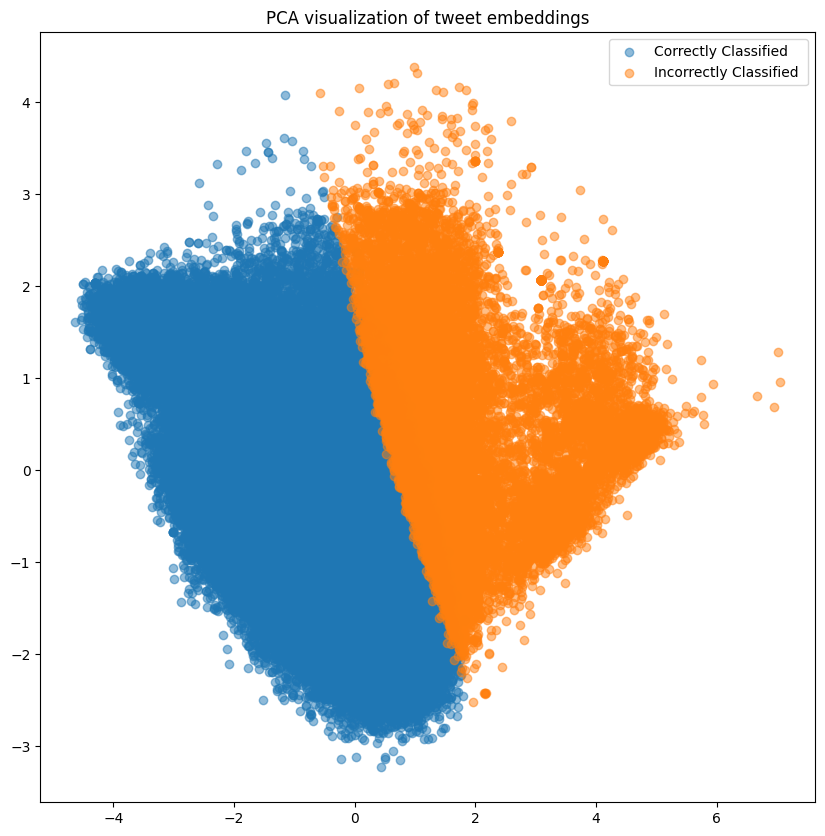

In [ ]:
import matplotlib.pyplot as plt
# Split your data into two sets based on the cluster labels
cluster_0 = all_embeddings_2d[:len(genuine_embeddings_200k_flat)][genuine_cluster_labels_200k == 0]
cluster_1 = all_embeddings_2d[:len(genuine_embeddings_200k_flat)][genuine_cluster_labels_200k == 1]

plt.figure(figsize=(10, 10))

# Create a scatter plot for each cluster
plt.scatter(cluster_0[:, 0], cluster_0[:, 1], marker='o', alpha=0.5, label='Correctly Classified')
plt.scatter(cluster_1[:, 0], cluster_1[:, 1], marker='o', alpha=0.5, label='Incorrectly Classified ')

plt.legend()
plt.title('PCA visualization of tweet embeddings')
plt.show()


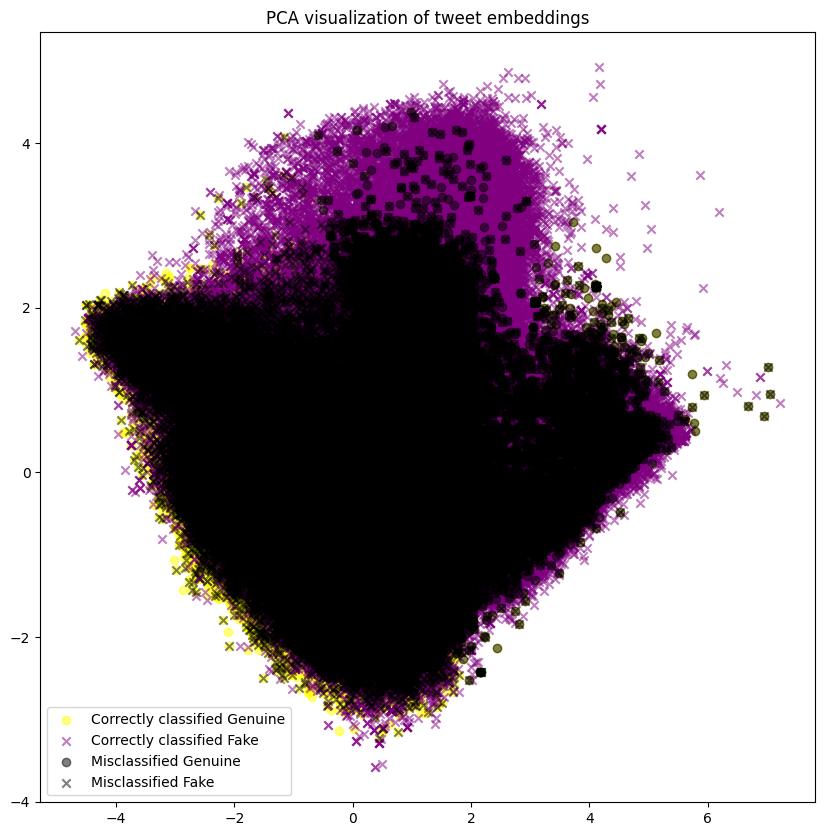

In [ ]:
plt.figure(figsize=(10, 10))

# Plot correctly classified points
plt.scatter(all_embeddings_2d[:len(genuine_embeddings_200k_flat), 0], all_embeddings_2d[:len(genuine_embeddings_200k_flat), 1],
            c='yellow', marker='o', alpha=0.5, label='Correctly classified Genuine')
plt.scatter(all_embeddings_2d[len(fake_embeddings_200k_flat):, 0], all_embeddings_2d[len(fake_embeddings_200k_flat):, 1],
            c='purple', marker='x', alpha=0.5, label='Correctly classified Fake')

# Overlay misclassified points
plt.scatter(all_embeddings_2d[misclassified_genuine, 0], all_embeddings_2d[misclassified_genuine, 1],
            c='black', marker='o', alpha=0.5, label='Misclassified Genuine')
plt.scatter(all_embeddings_2d[misclassified_fake, 0], all_embeddings_2d[misclassified_fake, 1],
            c='black', marker='x', alpha=0.5, label='Misclassified Fake')

plt.legend()
plt.title('PCA visualization of tweet embeddings')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, silhouette_score
from sklearn.utils import resample
import numpy as np

# Select a random sample of 20000 instances
n_samples = 20000
sampled_embeddings, sampled_cluster_labels = resample(all_embeddings_200k, cluster_labels, n_samples=n_samples, replace=False, random_state=0)

actual_labels = np.concatenate([np.zeros(len(genuine_embeddings_200k_flat)), np.ones(len(fake_embeddings_200k_flat))])

conf_matrix = confusion_matrix(actual_labels, cluster_labels)

if genuine_cluster_0 > genuine_cluster_1:
    predicted_labels = cluster_labels
else:
    predicted_labels = 1 - cluster_labels
f1 = f1_score(actual_labels, predicted_labels)

# Calculate the silhouette score for the sampled data
silhouette = silhouette_score(sampled_embeddings, sampled_cluster_labels, n_jobs=-1)

conf_matrix, f1, silhouette


In [ ]:
correct_classifications = np.sum(predicted_labels == actual_labels)
incorrect_classifications = np.sum(predicted_labels != actual_labels)
total_points = len(actual_labels)

correct_percentage = (correct_classifications / total_points) * 100
incorrect_percentage = (incorrect_classifications / total_points) * 100

print(f'correct: {round(correct_percentage, 2)}%\nincorrect: {round(incorrect_percentage, 2)}%')

correct: 67.58%
incorrect: 32.42%


### DBSCAN

### SVM(Support Vector Machine)- Supervised
#### For the purpose getting baseline of the dataset


In [ ]:
genuine_embeddings_200k = np.load(f'{root_path}/genuine_embeddings_200k_no_preprocessing.npy', allow_pickle=True)
fake_embeddings_200k = np.load(f'{root_path}/fake_embeddings_200k_no_preprocessing.npy', allow_pickle=True)

genuine_embeddings_200k.shape, fake_embeddings_200k.shape

((199342, 768), (199980, 768))

In [ ]:
df_genuine_200k_supervised = pd.DataFrame(genuine_embeddings_200k)
df_fake_200k_supervised = pd.DataFrame(fake_embeddings_200k)

In [ ]:
df_genuine_200k_supervised['bot'] = 0
df_fake_200k_supervised['bot'] = 1

In [ ]:
df_genuine_200k_supervised.shape, df_fake_200k_supervised.shape

((199342, 769), (199980, 769))

In [ ]:
df_combined_df_200k = pd.concat([df_genuine_200k_supervised, df_fake_200k_supervised])

In [ ]:
df_combined_df_200k.shape

(399322, 769)

In [ ]:
null_values = df_combined_df_200k.isnull()

null_values.sum()

0      0
1      0
2      0
3      0
4      0
      ..
764    0
765    0
766    0
767    0
bot    0
Length: 769, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [ ]:
X = df_combined_df_200k.iloc[:, :-1]  # all columns except the last one
y = df_combined_df_200k.iloc[:, -1]   # only the last column

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=717)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319457, 768), (319457,), (79865, 768), (79865,))

In [ ]:
# Let's take 20% of each
subset_ratio = 0.2

# Create subsets
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, stratify=y_train, test_size=(1-subset_ratio))
X_test_subset, _, y_test_subset, _ = train_test_split(X_test, y_test, stratify=y_test, test_size=(1-subset_ratio))

# Checking the shape of the created subsets
X_train_subset.shape, y_train_subset.shape, X_test_subset.shape, y_test_subset.shape


((63891, 768), (63891,), (15973, 768), (15973,))

In [ ]:
# Train
# clf = svm.SVC(kernel='linear')
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_train_subset, y_train_subset.ravel())

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

In [ ]:
from sklearn import metrics

# Use the model to make predictions on the test subset
y_pred_subset = clf.predict(X_test_subset)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test_subset, y_pred_subset)
precision = metrics.precision_score(y_test_subset, y_pred_subset, average='weighted')
recall = metrics.recall_score(y_test_subset, y_pred_subset, average='weighted')
f1_score = metrics.f1_score(y_test_subset, y_pred_subset, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.817931379914851
Precision: 0.8185702570340501
Recall: 0.817931379914851
F1 Score: 0.8178529684609254


In [ ]:
from sklearn import metrics

# Use the model to make predictions on the test subset
y_pred_subset = clf.predict(X_test_subset)

# Calculate metrics
accuracy = metrics.accuracy_score(y_test_subset, y_pred_subset)
precision = metrics.precision_score(y_test_subset, y_pred_subset, average='weighted')
recall = metrics.recall_score(y_test_subset, y_pred_subset, average='weighted')
f1_score = metrics.f1_score(y_test_subset, y_pred_subset, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.8280848932573718
Precision: 0.8287878215548486
Recall: 0.8280848932573718
F1 Score: 0.8280056390021088


In [ ]:
import pickle

# Save the model
with open(f'{root_path}/SVM_supervised_model_200k.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [ ]:
y_pred = clf.predict(X_test)